In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import umap.plot

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
from statannotations.Annotator import Annotator
import warnings

from pathlib import Path
import os

# Define directories for model and benchmark results
root_dir_model = Path.cwd().parents[0] / "FinalModelResults"
root_dir_bm = Path.cwd().parents[0] / "Benchmarks"

# Dataset control flags
merge_datasets = False
single_dataset = False
only_validation_compounds = False
test_plates_only = True

# Define dataset names and data stratifications
datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['test'] 

/opt/miniconda3/envs/FeatureAggregation/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
merge_datasets = True

datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['training', 'validation', 'test']
bigDF = []
for key in datasets:
    df = pd.read_csv(os.path.join(root_dir_model, f'mAP/{key}/FinalModelResults_{key}.csv'))
    # Remove BM columns and append to bottom of DF
    BMmap = pd.DataFrame(df.loc[:, ['plate', 'mAP BM']]).rename(columns={'mAP BM': 'mAP model'})
    df.drop('mAP BM', axis=1, inplace=True)
    df = pd.concat([df, BMmap])
    df['method'] = ['CytoSummaryNet']*(len(df)//2) + ['average profiling']*(len(df)//2)
    # Add platelabels
    platelabels = pd.read_csv(os.path.join(root_dir_bm, f'platelabels{key}.csv'))
    df = df.merge(platelabels, on='plate')

    # Add dataset columns
    if merge_datasets:
        if key == 'Stain5':
            df['dataset'] = ["out-of-distribution plates\nStain5"]*len(df)
        else:
            dataset_mapping = {
                'training':'training plates\nStain2-4',
                'validation': 'validation plates\nStain2-4',
                'test': 'test plates\nStain2-4'
            }
            df['dataset'] = df['platelabel'].map(dataset_mapping)
    else:
        df['dataset'] = [key]*len(df)
    bigDF.append(df)
bigDF = pd.concat(bigDF)

if merge_datasets:
    stratY = 4
    datasets = ['training plates\nStain2-4', 'validation plates\nStain2-4', 'test plates\nStain2-4', 'out-of-distribution plates\nStain5']
else:
    stratY = 4

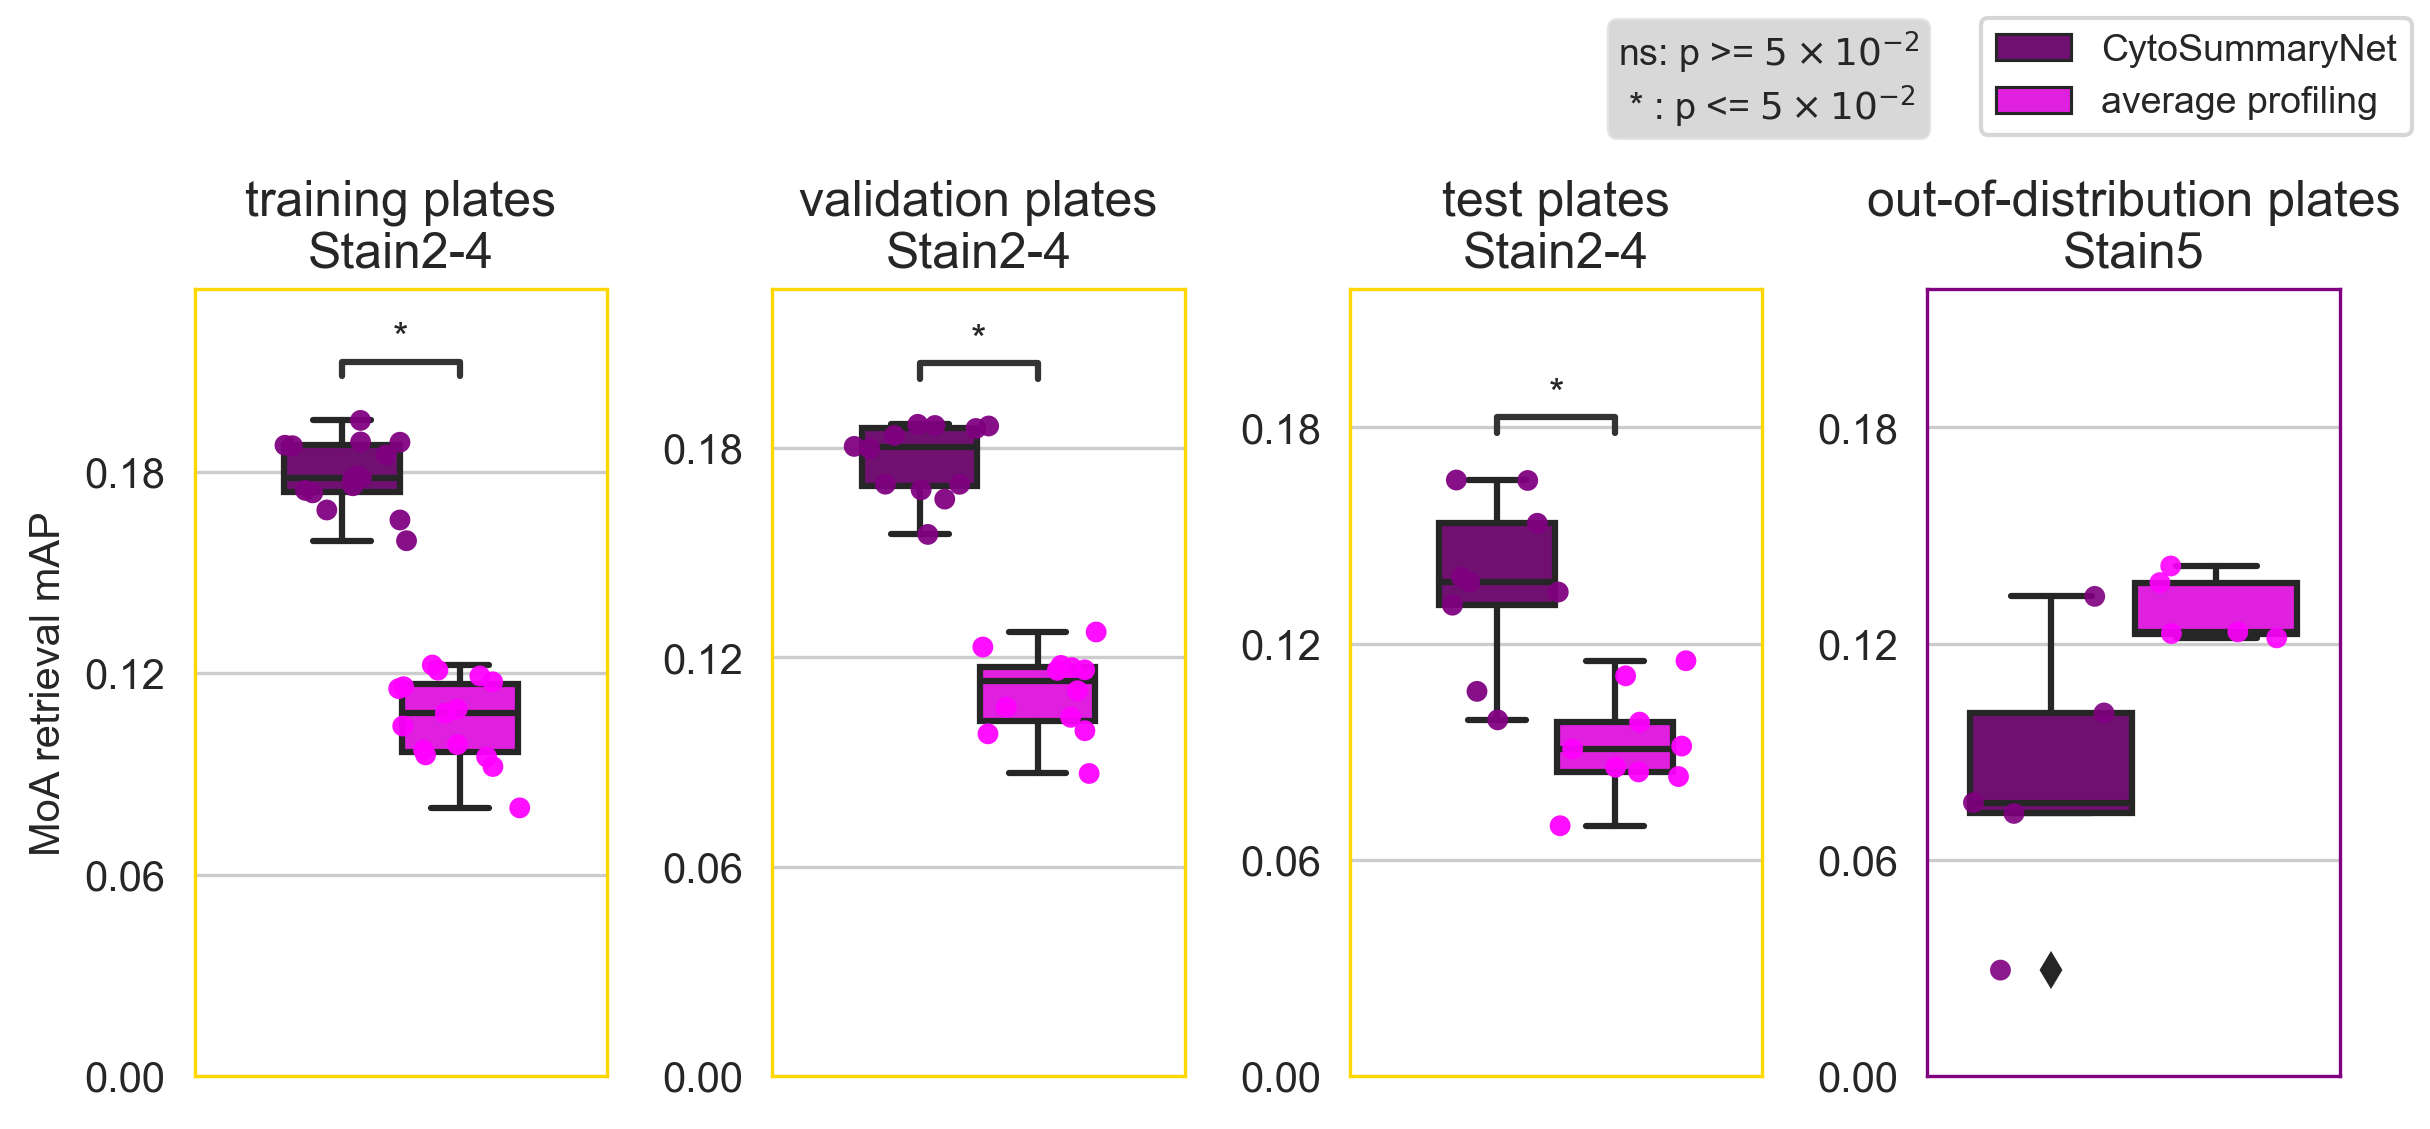

In [3]:
sns.set_style("whitegrid")

x = "dataset"
y = "mAP model"
hue = "method"
display_method = 'star' # star full simple

my_pal = {"CytoSummaryNet":"purple", "average profiling": 'magenta'}

MAX_Y = 0.21838374167146757

fig, ax = plt.subplots(1, stratY, dpi=300, figsize=(8, 3))
# First loop over different datasets 
for dataset_idx in range(stratY):
    cdataset = datasets[dataset_idx]
    subDF = bigDF.loc[bigDF['dataset'] == cdataset]
    # Then over different stratifications 
    subsubDF = subDF.copy()

    if dataset_idx==stratY-1:
        fakeax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], palette=my_pal)
        handles, labels = fakeax.get_legend_handles_labels()
        sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], alpha=0.9, dodge=True, jitter=0.4, palette=my_pal)
        
        fakeax.legend([],[], frameon=False)
        fakeax.set(ylabel=None)
        fakeax.set(xticklabels=[])
        fakeax.set(xlabel=None)
        
        fakeax.set_ylim(0, MAX_Y)
        fakeax.yaxis.set_major_locator(plt.MaxNLocator(4))
        continue
    
    with sns.plotting_context("notebook", font_scale = 0.8):
        subax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], palette=my_pal)
        sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], alpha=0.94, dodge=True, jitter=0.5, palette=my_pal)
        box_pairs=[((cdataset, 'CytoSummaryNet'), (cdataset, 'average profiling'))]
        
        subax.set_ylim(0, MAX_Y)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            annotator = Annotator(subax, pairs=box_pairs, data=subsubDF, x=x, y=y, hue=hue)
            annotator.configure(test='t-test_welch', text_format=display_method, 
                                loc='inside', test_short_name='t-test welch', verbose=False)
            annotator.apply_and_annotate()

        # remove all the labels and ticks 
        subax.set(xticklabels=[])
        subax.set(xlabel=None)
        subax.tick_params(bottom=False)
        if dataset_idx != 0:
            subax.set(ylabel=None)
        else:
            subax.set(ylabel="MoA retrieval mAP")

        subax.legend([],[], frameon=False)
        subax.yaxis.set_major_locator(plt.MaxNLocator(4))
        
plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.4)

fig.legend(handles, labels, loc='upper right', fontsize=9)

textstring = r'ns: p >= $5\times10^{-2}$'+'\n'+r' * : p <= $5\times10^{-2}$'
#+'\n**: $10^{-3}$ < p <= $10^{-2}$\n***: $10^{-4}$ < p <= $10^{-3}$\n****: p <= $10^{-4}$
props = dict(boxstyle='round', facecolor='grey', alpha=0.3)
fig.text(0.65, 1.33, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)

# Set colours
for a in ax.flat[:3]:
    for spine in a.spines.values():
        spine.set_edgecolor('gold')
for spine in ax.flat[-1].spines.values():
    spine.set_edgecolor('purple')

titles = ['training plates\nStain2-4', 'validation plates\nStain2-4', 'test plates\nStain2-4', 'out-of-distribution plates\nStain5']

for a, title in zip(ax.flat, titles):
    a.set_title(title, pad=5)

# Get the minimum and maximum y-axis values across all subplots
min_y = 0
max_y = max(a.get_ylim()[1] for a in ax.flatten())

if not merge_datasets:
    plt.savefig(os.path.join("Figures", 'Figure5_MOAmAP.svg'), format='svg', bbox_inches='tight')
else:
    plt.savefig(os.path.join("Figures", 'Figure5_MOAmAP_merged.svg'), format='svg', bbox_inches='tight')
